In [4]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.io import fits
import glob
from astropy import units as u
from astropy import constants as const
import time
from dust_extinction.parameter_averages import F99
from spec_modelfit import *

%load_ext autoreload
%autoreload 2

%matplotlib inline

## Load data spectrum and define grid of models to compare against:

In [58]:
# shamelessly stolen out of the astropy specutils library: 
# https://github.com/astropy/specutils/blob/0933a8e271ab1e333337087433cb683da8ab5a54/specutils/utils/wcs_utils.py#L366    
def vac_to_air(wavelength):
    """
    Griesen 2006 reports that the error in naively inverting Eqn 65 is less
    than 10^-9 and therefore acceptable.  This is therefore eqn 67
    """
    wlum = wavelength.to(u.um).value
    nl = (1+1e-6*(287.6155+1.62887/wlum**2+0.01360/wlum**4))
    return wavelength/nl    

def air_to_vac(wavelength):
    """
    Implements the air to vacuum wavelength conversion described in eqn 65 of
    Griesen 2006
    """
    wlum = wavelength.to(u.um).value
    return (1+1e-6*(287.6155+1.62887/wlum**2+0.01360/wlum**4)) * wavelength

In [235]:
# newest xshooter spectrum instead
# data = np.loadtxt('../RV/xshooter_oct_medvis.txt', skiprows=1) # optical Oct data
# data = np.loadtxt('../RV/xshooter_dec_medvis.txt', skiprows=1) # optical Dec data
data = np.loadtxt('../RV/xshooter_mednir_dec.txt', skiprows=1) # NIR Dec data


wavelength_object = np.nan_to_num(data[:, 0])
flux_object = np.nan_to_num(data[:, 1])
uncertainty_object = np.nan_to_num(data[:, 2])

In [236]:
# Do conversion from air (X-shooter) to vacuum (BT Settl)
wv_obj_vac = air_to_vac(wavelength_object*u.nanometer)
wavelength_object = wv_obj_vac.value

In [237]:
# set type of data!
optical = False
NIR = True
UV = False

In [238]:
# trim the noisy parts - OPTICAL:
if optical==True:
    flux_object = flux_object[wavelength_object > 670]
    uncertainty_object = uncertainty_object[wavelength_object > 670]
    wavelength_object = wavelength_object[wavelength_object > 670]/1000 # to microns

In [239]:
# trim the noisy parts - NIR:
if NIR == True:
    flux_object = flux_object[wavelength_object < 2200]
    uncertainty_object = uncertainty_object[wavelength_object < 2200]
    wavelength_object = wavelength_object[wavelength_object < 2200]/1000 # to microns    

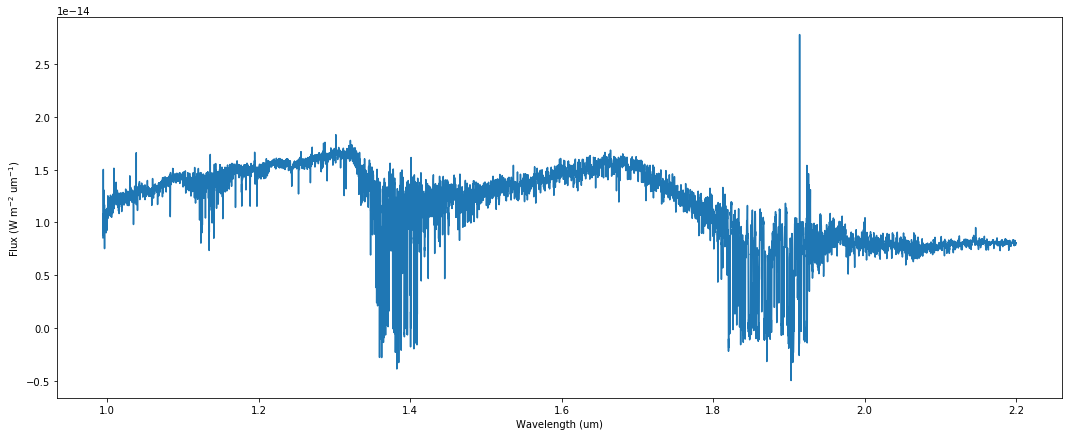

In [240]:
# plot reduced spectrum:
fig = plt.figure(figsize=(18,7))
plt.plot(wavelength_object, flux_object)
plt.xlabel('Wavelength (um)')
plt.ylabel(r'Flux (W m$^{-2}$ um$^{-1}$)')
plt.show()

In [241]:
modellst = glob.glob('../../HD206893_Analysis/GOI46/SpectralFitting/BT-Settl15_formatted/lte02*fits')

In [242]:
len(modellst)

94

In [243]:
models = [x for x in modellst if "-2.5-" not in x]

# mini subset for testing
# models = models[:3]

# set up parameters for scaling object radius:
sclrng = np.arange(0.1, 1.0, 0.2) # solar radii!

dist = 119.37 # Gaia DR2

# set up extinction parameters:
ext = F99(Rv=3.1) 
avrng = np.arange(0.5, 3.5, 0.5) 

len(models)

80

In [244]:
def calc_bestmodel(wavelength_object, flux_object, uncertainty_object, models, dist, sclrng, avrng):
    
    dof = len(wavelength_object) - 1
    minchi2 = np.zeros(len(models))
    minradius = np.zeros(len(models))
    
    # set up dictionary to store chi2 values
    chi2_dict = dict()

    for ii, model in enumerate(models):
        print(model)

        for scl in sclrng:
            #print(scl)

            # rescale synthetic atmosphere model
            wv, flam = rescaleModel(model, dist, scl, rjup=False, highres=True)

            # rebin the model to the data coarseness
            model_rebinflux = rebinspec(wv, flam.value, wavelength_object)
            
            for av in avrng:
                #print(av)
                
                # add extinction to the model 
                spectrum_ext = model_rebinflux*ext.extinguish(wavelength_object*u.um, Av=av)

                # calculate chi2 value for the extincted model
                tmp_chi2 = np.nansum(((flux_object - spectrum_ext)/uncertainty_object)**2) / dof 
                
                # add dictionary entry with tuple and chi2 value:
                chi2_dict[(model, scl, av)] = tmp_chi2
                print(tmp_chi2)


    minchi2 = min(chi2_dict.values())
    
    result = [k for k,v in chi2_dict.items() if v==minchi2]
    
        
    return result, minchi2

In [245]:
t0 = time.time()

result, chi2 = calc_bestmodel(wavelength_object, flux_object, uncertainty_object, models, dist, sclrng, avrng)
    
t1 = time.time()

print("Time taken: ", np.round((t1-t0)/60., 2), " minutes")

../../HD206893_Analysis/GOI46/SpectralFitting/BT-Settl15_formatted/lte020.0-3.0-0.0a+0.0.BT-Settl.fits


/Users/kwardduong/anaconda3/lib/python3.7/site-packages/dust_extinction/helpers.py:28: UserWarning: x has no units, assuming x units are inverse microns
  warnings.warn("x has no units, assuming x units are inverse microns")


147349.22836789256
148033.03420188287
148666.4033172021
149253.23577686845
149797.1290955628
150301.39835178576
83958.95898294271
88051.27293989337
91991.98187214967
95768.19067551494
99372.55628783538
102801.92681562966
37607.151701338655
37519.47630974358
38690.26164591978
40817.04535731302
43658.759525264024
47023.38444573627
169151.26949967156
135301.096099092
108855.48796626237
88437.68959127273
72926.43651361579
61406.57264694315
719877.5068428279
589691.309989426
482629.02882480196
394686.95803090907
322581.63381154096
263612.6935265065
../../HD206893_Analysis/GOI46/SpectralFitting/BT-Settl15_formatted/lte020.0-3.5-0.0a+0.0.BT-Settl.fits
147052.963895443
147755.0871844986
148405.669321325
149008.67338712316
149567.75626832718
150086.28916566764
81775.66228958168
85980.17983782908
90028.08056916214
93906.82325084235
97609.3103111877
101132.5661312138
34226.236212472715
34157.717995088686
35361.11724821104
37533.769638972204
40433.68441498106
43867.504714843344
170415.03993334365


In [246]:
result, chi2

([('../../HD206893_Analysis/GOI46/SpectralFitting/BT-Settl15_formatted/lte028.0-5.5-0.0a+0.0.BT-Settl.fits',
   0.30000000000000004,
   3.0)],
 22212.556863059875)

In [247]:
wv, flam = rescaleModel('../../HD206893_Analysis/GOI46/SpectralFitting/BT-Settl15_formatted/lte028.0-5.5-0.0a+0.0.BT-Settl.fits', dist, 0.3, rjup=False, highres=True)

In [248]:
flam

<Quantity [1.21631177e-15, 1.89471944e-16, 2.81478294e-16, ...,
           3.71744807e-16, 3.22957155e-16, 4.59351259e-16] rad2>

In [249]:
model_rebinflux = rebinspec(wv, flam.value, wavelength_object)

In [250]:
model_rebinflux

array([3.16406146e-14, 2.97274647e-14, 2.65334272e-14, ...,
       9.08226544e-15, 9.11685213e-15, 9.11685213e-15])

In [251]:
av = 3.0
spectrum_ext = model_rebinflux*ext.extinguish(wavelength_object*u.um, Av=av)

/Users/kwardduong/anaconda3/lib/python3.7/site-packages/dust_extinction/helpers.py:28: UserWarning: x has no units, assuming x units are inverse microns
  warnings.warn("x has no units, assuming x units are inverse microns")


In [252]:
spectrum_ext

array([1.10657496e-14, 1.03978074e-14, 9.28165044e-15, ...,
       6.70926132e-15, 6.73488749e-15, 6.73496373e-15])

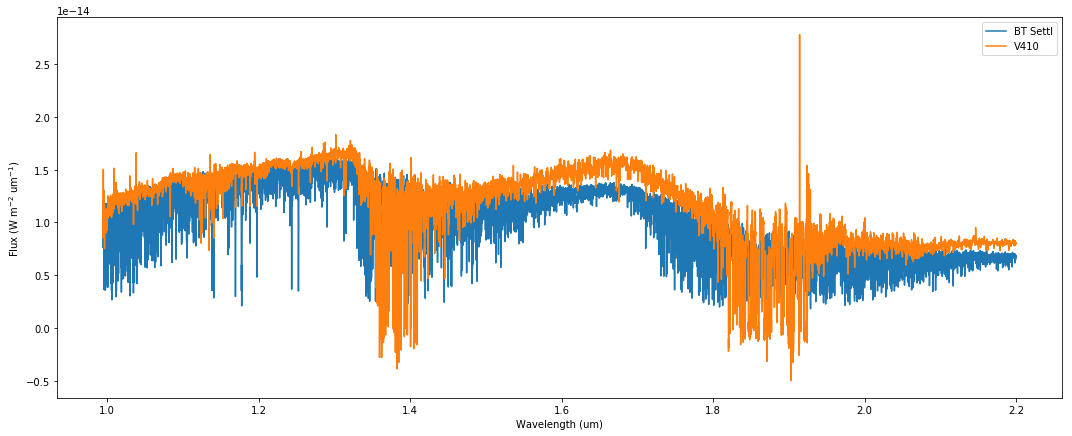

In [253]:
# plot reduced spectrum:
fig = plt.figure(figsize=(18,7))

plt.plot(wavelength_object, spectrum_ext, label='BT Settl')
plt.plot(wavelength_object, flux_object, label='V410')
plt.legend()
plt.xlabel('Wavelength (um)')
plt.ylabel(r'Flux (W m$^{-2}$ um$^{-1}$)')
# plt.xlim(0.805,0.83)
# plt.xlim(0.75, 0.79)
# plt.xlim(0.8, 0.9)
plt.show()

In [254]:
# Just out of curiosity - normalizing 

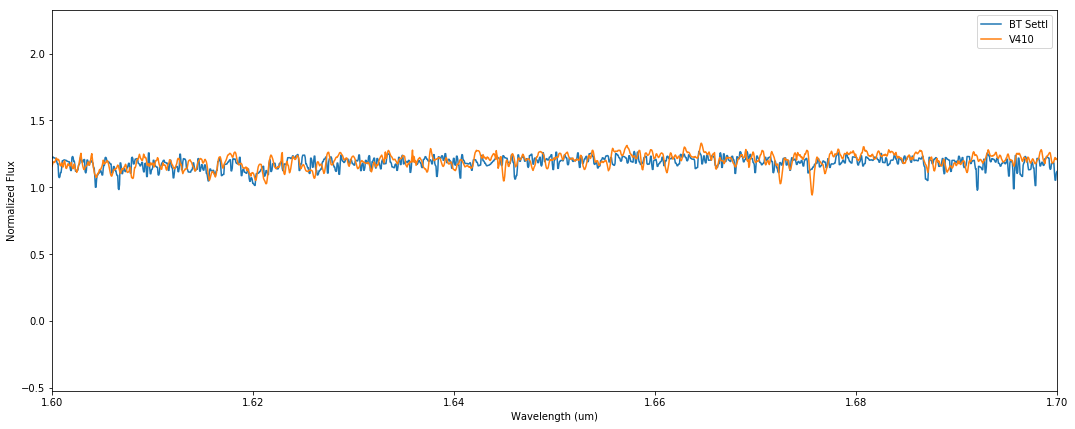

In [258]:
fig = plt.figure(figsize=(18,7))

plt.plot(wavelength_object, spectrum_ext/np.median(spectrum_ext), label='BT Settl')
plt.plot(wavelength_object, flux_object/np.median(flux_object), label='V410')
plt.legend()
plt.xlabel('Wavelength (um)')
plt.ylabel(r'Normalized Flux')
# plt.xlim(0.805,0.83)
# plt.xlim(0.75, 0.79)
plt.xlim(1.6, 1.7)
plt.show()

In [259]:
## Save the output such that the these can be used for cross-correlating elsewhere:
np.savetxt('../RV/BTSettl_Xshooter_forXCorr_Dec_NIR.txt', np.c_[wavelength_object, flux_object, uncertainty_object, spectrum_ext])

## A quick RV test...

In [130]:
from PyAstronomy import pyasl

In [176]:
fit_region = (wavelength_object > 0.95) & (wavelength_object < 0.99)
fit_region = (wavelength_object > 0.7) & (wavelength_object < 1.0)

In [177]:
# normalize data:
dw = wavelength_object[fit_region]
df = (flux_object[fit_region])/np.median(flux_object[fit_region])

# template:
tw = wavelength_object[fit_region] # since we've resampled to the same wavelength axis
tf = (spectrum_ext[fit_region]/np.median(spectrum_ext[fit_region]))

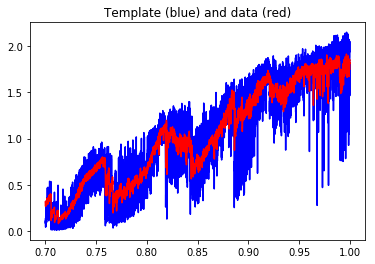

In [178]:
# Plot template and data
plt.title("Template (blue) and data (red)")
plt.plot(tw, tf, 'b-')
plt.plot(dw, df, 'r-')
# plt.xlim(2.28, 2.32)
plt.show()

In [179]:
# Carry out the cross-correlation.
# The first and last 20 points of the data are skipped.
rv, cc = pyasl.crosscorrRV(dw, df, tw, tf, -50., 50., 10/100., skipedge=10, mode='doppler')

Cross-correlation function is maximized at dRV =  18.000000000000966  km/s
  A red-shift with respect to the template


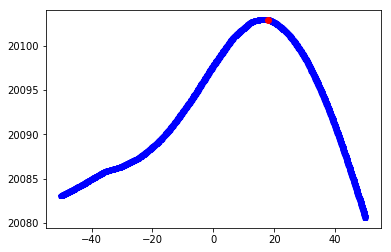

In [180]:
# Find the index of maximum cross-correlation function
maxind = np.argmax(cc)

print("Cross-correlation function is maximized at dRV = ", rv[maxind], " km/s")
if rv[maxind] > 0.0:
  print("  A red-shift with respect to the template")
else:
  print("  A blue-shift with respect to the template")

plt.plot(rv, cc, 'bp-')
plt.plot(rv[maxind], cc[maxind], 'ro')
plt.show()
